# Implementation using Resnet50 de TensorFlow

In [2]:
! git clone -b Melanie_Beraud https://github.com/kumquat42/ProjetFinal_JedhaDS27_Emotions.git

Cloning into 'ProjetFinal_JedhaDS27_Emotions'...
remote: Enumerating objects: 34501, done.
remote: Total 34501 (delta 0), reused 0 (delta 0), pack-reused 34501
Receiving objects: 100% (34501/34501), 232.59 MiB | 14.16 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Updating files: 100% (71782/71782), done.


In [110]:
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib

import tensorflow as tf
# from pathlib import Path
tf.__version__
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import resnet50

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight


# Importation Images

- Data augmentation for train only
-

In [5]:
train_dir = "/content/ProjetFinal_JedhaDS27_Emotions/Datasets/FER2013/train"
test_dir = "/content/ProjetFinal_JedhaDS27_Emotions/Datasets/FER2013/test"

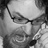

In [6]:
with Image.open(f'{test_dir}/angry/PrivateTest_10131363.jpg') as img:
#with Image.open(f'{train_dir}/angry/Training_10118481.jpg') as img:
  display(img)


In [125]:
# Parameters

BATCH_SIZE = 64

FINE_TUNING = 90

EARLY_STOPPING_CRITERIA = 3
EPOCHS = 30


#  Class labels : 0,, 1, 2, 3, 4, 5, 6. cf. surprise =6 [0. 0. 0. 0. 0. 0. 1.]
CLASS_LABELS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
'''
class_weight = {0: 28709/3995/2.0,
                1: 28709/436/2.0,
                2: 28709/4097/2.0,
                3: 28709/7215/2.0,
                4: 28709/4965/2.0,
                5: 28709/4830/2.0,
                6: 28709/3171/2.0}
'''
weight = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)

class_weight = {}
classe = [0, 1, 2, 3, 4, 5, 6]
for clas, weig in zip(classe, weight):
  class_weight[clas] = weig
class_weight


{0: 1.026559068389601,
 1: 9.38328664799253,
 2: 1.001145646543136,
 3: 0.5684588624600504,
 4: 0.8260315633733355,
 5: 0.8492415599780285,
 6: 1.2933719433719433}

In [52]:
# Data augmentation to add a few weird stuffs for the train only
train_datagen = ImageDataGenerator(
    rotation_range = 45,
    width_shift_range = 0.1,        # Randomly shift the width of images by up to 10%
    height_shift_range = 0.1,   # Randomly shift the height of images by up to 10%
    brightness_range=(0.5, 1),
    rescale = 1./255,
    validation_split = 0.3 # permet de ne spécifier que le train generator dans la validation
)

train_generator = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size = (48, 48),
    batch_size = BATCH_SIZE,
    color_mode = "rgb",     #grayscale
    class_mode = "categorical",
    shuffle=True,
    subset="training"
)


validation_generator = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size = (48, 48),
    batch_size = BATCH_SIZE,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle=True,
    subset="validation"
)


# On 28709 images:
# Found 20099 images belonging to 7 classes.
# Found 8610 images belonging to 7 classes.


Found 20099 images belonging to 7 classes.
Found 8610 images belonging to 7 classes.


In [ ]:
from pathlib import Path

# voir les images - à tester...
imgs, labels = next(iter(train_generator))
for img, label in zip(imgs, labels):
  true_file_path = np.argmax(train_generator.labels == tf.argmax(label)) # Je cherche n'importe quelle index avec une valeur True
  true_label_name = Path(train_generator.filepaths[true_file_path]).parent.name
  print(label)
  plt.imshow(img)
  plt.title(true_label_name)
  plt.show()


In [ ]:
# with Image.open('/home/melb/Documents/Projects/Projet final/ProjetFinal_JedhaDS27_Emotions/FER2013/train/angry/Training_8521861.jpg') as im:
#        im.show()

array_rgb = np.array(im.convert(mode = 'RGB')).reshape(48,48,3) # ValueError: cannot reshape array of size 2304 into shape (48,48,3)
# im_rgb = Image.fromarray(array_rgb)
# im_rgb.show()

Maybe useless

# models

Import du modèle resnet avec les poids Imagenet

resnet_model_1 :
- Données : 28709 images (train), val 7178 imags (test)
- Batch 64
- Poids du modèle Imagenet. Je unfreeze la dernière couche
- Paramètres:
 input_[(None, 48, 48, 3)]
 output (None, 2, 2, 2048)    

Total params: 23587712 (89.98 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 23587712 (89.98 MB)

class_res_1:  
Réentrainement seulement sur la dernière couche + en dense 7  
Paramètres:
Total params: 23602055 (90.03 MB)
Trainable params: 14343 (56.03 KB)
Non-trainable params: 23587712 (89.98 MB)
his_res_1

Résultats pourris

class_res_30:
Réentrainement seulement sur les 30 dernières couches + en dense 7  

Total params: 23602055 (90.03 MB)
Trainable params: 14464519 (55.18 MB)
Non-trainable params: 9137536 (34.86 MB)

loss: 6.2740 - categorical_accuracy: 0.2685 - val_loss: 2.2445 - val_categorical_accuracy: 0.1689

class_60:

Total params: 23602055 (90.03 MB)
Trainable params: 18083591 (68.98 MB)
Non-trainable params: 5518464 (21.05 MB)

loss: 6.4469 - categorical_accuracy: 0.2479 - val_loss: 8.9684 - val_categorical_accuracy: 0.1734

class_90
Total params: 23602055 (90.03 MB)
Trainable params: 21377031 (81.55 MB)
Non-trainable params: 2225024 (8.49 MB)

loss: 6.3343 - categorical_accuracy: 0.2558 - val_loss: 5.4497 - val_categorical_accuracy: 0.2526

resnet_model_2 :
- Batch 64
- poids Imagenet pour commencer quelque part, mais trainable  = complete True
- Paramètres:
 input_[(None, 48, 48, 3)]
 output (None, 2, 2, 2048)

Total params: 23587712 (89.98 MB)
Trainable params: 23534592 (89.78 MB)
Non-trainable params: 53120 (207.50 KB)   

class_res_all.
loss: 8.1049 - categorical_accuracy: 0.1462 - val_loss: 2.0769 - val_categorical_accuracy: 0.1717
Epoch 4: early stopping

Total params: 23587712 (89.98 MB)
Trainable params: 23534592 (89.78 MB)
Non-trainable params: 53120 (207.50 KB)  


class_res_all_class:
idem, but with class_weight automatic

Total params: 23587712 (89.98 MB)
Trainable params: 23534592 (89.78 MB)
Non-trainable params: 53120 (207.50 KB)  

loss: 2.3560 - categorical_accuracy: 0.1364 - val_loss: 2.0739 - val_categorical_accuracy: 0.1375

class_res_all_Noclass
idem sans les class weight

loss: 2.1202 - categorical_accuracy: 0.2364 - val_loss: 2.3026 - val_categorical_accuracy: 0.2404

In [93]:
resnet_model_2 = tf.keras.applications.resnet50.ResNet50(input_shape=(48,48,3), # ne fonctionne pas avec 48, 48, 1 car les images sont censées être en couleur...
                                               include_top=False,
                                               weights = None
                                               )

resnet_model_2.trainable = True # on train tout modele 2

In [94]:
print(len(resnet_model_2.layers)) # 175
resnet_model_2.summary()

175
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 54, 54, 3)            0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 24, 24, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 24, 24, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                   

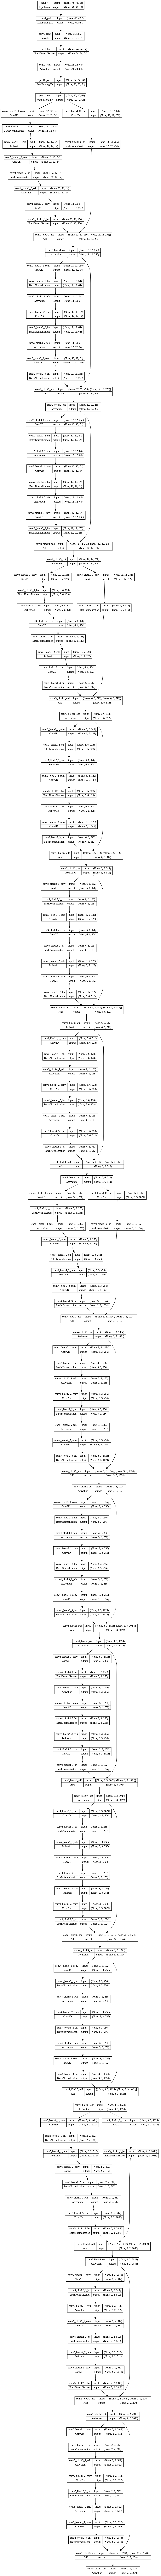

In [96]:
tf.keras.utils.plot_model(resnet_model_2, show_shapes=True)

In [132]:

'''
resnet_model_1.trainable = True

fine_tune_at = len(resnet_model_1.layers) - FINE_TUNING

for layer in resnet_model_1.layers[:fine_tune_at]:
  layer.trainable = False
'''
# ajout de la couche dense:
class_res_all_Noclass = tf.keras.Sequential([
    resnet_model_2,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation="softmax")
  ])

class_res_all_Noclass.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_max_pooling2d_10 (G  (None, 2048)              0         
 lobalMaxPooling2D)                                              
                                                                 
 flatten_10 (Flatten)        (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 7)                 14343     
                                                                 
Total params: 23602055 (90.03 MB)
Trainable params: 23548935 (89.83 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [133]:
class_res_all_Noclass.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [134]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', # On s'arrête quand la loss est au plateau
                                                         patience= EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = class_res_all_Noclass.fit(x = train_generator,
                    epochs = EPOCHS,
                    validation_data = validation_generator,
                    callbacks= [earlyStoppingCallback])
                    #class_weight=class_weight)


his_res_all_Noclass = pd.DataFrame(history.history)



Epoch 1/30
315/315 [==============================] - 103s 206ms/step - loss: 2.0889 - categorical_accuracy: 0.2443 - val_loss: 2.6260 - val_categorical_accuracy: 0.2330
Epoch 2/30
315/315 [==============================] - 55s 175ms/step - loss: 2.1166 - categorical_accuracy: 0.2428 - val_loss: 1.8135 - val_categorical_accuracy: 0.2513
Epoch 3/30
315/315 [==============================] - 56s 177ms/step - loss: 2.0663 - categorical_accuracy: 0.2454 - val_loss: 60.1905 - val_categorical_accuracy: 0.2109
Epoch 4/30
315/315 [==============================] - 56s 178ms/step - loss: 2.0728 - categorical_accuracy: 0.2452 - val_loss: 2.1915 - val_categorical_accuracy: 0.2319
Epoch 5/30
315/315 [==============================] - 56s 179ms/step - loss: 2.1202 - categorical_accuracy: 0.2364 - val_loss: 2.3026 - val_categorical_accuracy: 0.2404
Epoch 5: early stopping


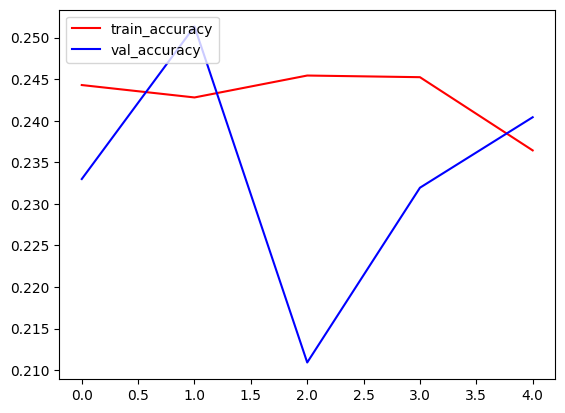

In [135]:
plt.plot(his_res_all_Noclass["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(his_res_all_Noclass["val_categorical_accuracy"], c="b", label="val_accuracy")
plt.legend(loc="upper left")
plt.show()

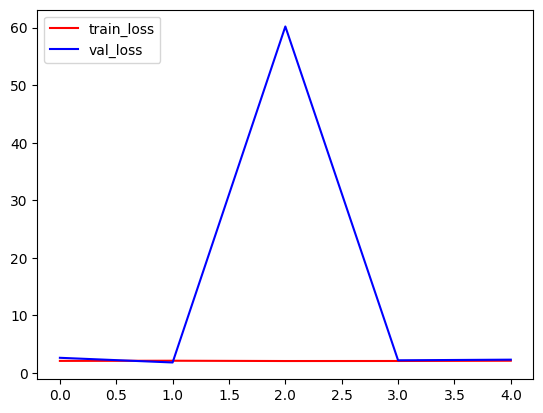

In [136]:
plt.plot(his_res_all_Noclass["loss"], c="r", label="train_loss")
plt.plot(his_res_all_Noclass["val_loss"], c="b", label="val_loss")
plt.legend(loc="upper left")
plt.show()

In [137]:
class_res_all_Noclass.save("/content/ProjetFinal_JedhaDS27_Emotions/class_res_all_Noclass.h5")
his_res_all_Noclass.to_csv('/content/ProjetFinal_JedhaDS27_Emotions/his_res_all_Noclass.csv')
joblib.dump(class_res_all_Noclass, "/content/ProjetFinal_JedhaDS27_Emotions/class_res_all_Noclass.sav")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['/content/ProjetFinal_JedhaDS27_Emotions/class_res_all_Noclass.sav']

In [ ]:
his_res_all.head()

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,1.796947,0.257341,1.758335,0.288799
1,1.796650,0.256784,1.746512,0.295486
2,1.793318,0.259884,1.735345,0.299805
3,1.788222,0.260615,1.774619,0.258707
4,1.784873,0.264447,1.768106,0.308860


# Classweight

In [37]:
import os

sum = 0

for item in os.listdir('ProjetFinal_JedhaDS27_Emotions/Datasets/FER2013/train'):
  count = 0
  for img in os.listdir(f'ProjetFinal_JedhaDS27_Emotions/Datasets/FER2013/train/{item}'):
    count +=1

  sum = sum + count
  print(item, count)

print(sum)

'''
surprise 3171
neutral 4965
angry 3995
happy 7215
disgust 436
sad 4830
fear 4097
28709
'''

surprise 3171
neutral 4965
angry 3995
happy 7215
disgust 436
sad 4830
fear 4097
28709


In [48]:
3995/28709 + 3171/28709 + 4965/28709 + 7215/28709 + 436/28709 +4830/28709 + 4097/28709
28709/436/2.0, 28709/3995/2.0,

32.92316513761468

In [50]:
CLASS_LABELS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

class_weight = {0: 28709/3995/2.0,
                1: 28709/436/2.0,
                2: 28709/4097/2.0,
                3: 28709/7215/2.0,
                4: 28709/4965/2.0,
                5: 28709/4830/2.0,
                6: 28709/3171/2.0}

# Scaling by total/2 helps keep the loss to a similar magnitude.

class_weight ={0: 3.593116395494368,
 1: 32.92316513761468,
 2: 3.503661215523554,
 3: 1.9895356895356895,
 4: 2.8911379657603224,
 5: 2.9719461697722567,
 6: 4.526805424156418}

{0: 3.593116395494368,
 1: 32.92316513761468,
 2: 3.503661215523554,
 3: 1.9895356895356895,
 4: 2.8911379657603224,
 5: 2.9719461697722567,
 6: 4.526805424156418}

# GRAD CAM

In [139]:
## Create an object `imgs` and an object `labels` containing a batch of validation images and validation labels.
model = class_res_all_Noclass
imgs, labels = next(iter(train_generator))


In [142]:

## 2. Get the name of the last convolution layer of the pretrained model and the predicition layers and store them in two variables called respectively `last_conv_layer_name`, and `classifier_layer_names`.
for layer in model.layers:
  print(layer.name)
print()
base_model = model.layers[0]

resnet50
global_max_pooling2d_10
flatten_10
dense_10



In [144]:
last_conv_layer_name = "conv5_block3_out"
classifier_layer_names = [layer.name for layer in model.layers][1:]
classifier_layer_names

['global_max_pooling2d_10', 'flatten_10', 'dense_10']

In [151]:
## 3. Run the following command, these functions will help you produce the grad cam

# We start by setting up the dependencies we will use
# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [147]:
# The Grad-CAM algorithm
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, base_model, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(base_model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap



2/2 [==============================] - 2s 15ms/step
Prediction output: [[0.12699486 0.01190279 0.12492033 0.23863755 0.18400547 0.21731357
  0.0962255 ]
 [0.12018938 0.01449792 0.14191136 0.23729154 0.16579275 0.18660937
  0.1337077 ]
 [0.1172892  0.0151929  0.13552405 0.24228698 0.17205139 0.18478061
  0.13287492]
 [0.12029073 0.01394329 0.14014925 0.23118429 0.17252779 0.18647207
  0.13543253]
 [0.12485451 0.01242902 0.13046938 0.23523706 0.17568101 0.21968523
  0.10164385]
 [0.1273313  0.0129421  0.12312213 0.24143328 0.18843736 0.21428093
  0.09245285]
 [0.12433276 0.0135457  0.12853867 0.24241999 0.17759739 0.19916293
  0.11440255]
 [0.1276896  0.01238485 0.12760675 0.24189043 0.1793658  0.2169691
  0.09409346]
 [0.12138639 0.01456815 0.13452399 0.2399043  0.17349344 0.18965392
  0.12646978]
 [0.12895402 0.01192951 0.12614192 0.24128805 0.18178837 0.22148648
  0.08841161]
 [0.12428369 0.01519732 0.13086894 0.24498172 0.17279585 0.19471122
  0.11716132]
 [0.12580398 0.01383963 0.13

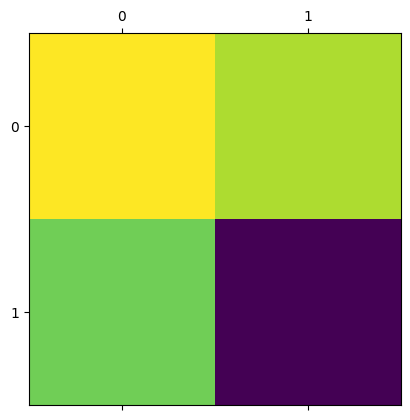

In [148]:
## 4. Create a `preds` object containing the predicitons from your model on the batch of validation images.

## Then create a `pred_labels` object containing the top class predicted for each image in that batch. (You can use the `tf.argmax` function for this)

# Print what the top predicted class is
preds = model.predict(imgs)
pred_labels = tf.argmax(preds, axis = -1)

print("Prediction output:", preds)

print("Predicted label:", pred_labels)

# Generate class activation heatmap
heatmaps = []

for img in imgs:
  heatmap = make_gradcam_heatmap(
    tf.expand_dims(img,axis=0),base_model, model, last_conv_layer_name, classifier_layer_names
  )
  heatmaps.append(heatmap)


# Display heatmap
plt.matshow(heatmaps[0])
plt.show()



Predicted label: happy
True label: sad


<ipython-input-150-66b0a8c7f657>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


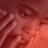

Predicted label: happy
True label: neutral


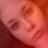

Predicted label: happy
True label: sad


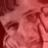

Predicted label: happy
True label: happy


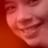

Predicted label: happy
True label: happy


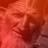

Predicted label: happy
True label: sad


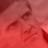

Predicted label: happy
True label: fear


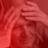

Predicted label: happy
True label: surprise


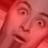

Predicted label: happy
True label: happy


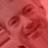

Predicted label: happy
True label: happy


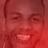

Predicted label: happy
True label: fear


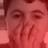

Predicted label: happy
True label: neutral


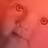

Predicted label: happy
True label: happy


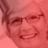

Predicted label: happy
True label: happy


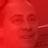

Predicted label: happy
True label: surprise


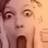

Predicted label: happy
True label: angry


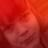

Predicted label: happy
True label: sad


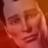

Predicted label: happy
True label: fear


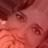

Predicted label: happy
True label: happy


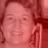

Predicted label: happy
True label: fear


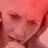

Predicted label: happy
True label: happy


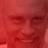

Predicted label: happy
True label: sad


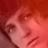

Predicted label: happy
True label: neutral


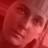

Predicted label: happy
True label: surprise


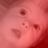

Predicted label: happy
True label: sad


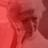

Predicted label: happy
True label: happy


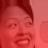

Predicted label: happy
True label: neutral


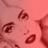

Predicted label: happy
True label: surprise


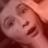

Predicted label: happy
True label: sad


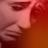

Predicted label: happy
True label: neutral


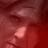

Predicted label: happy
True label: fear


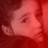

Predicted label: happy
True label: happy


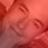

Predicted label: happy
True label: fear


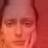

Predicted label: happy
True label: neutral


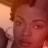

Predicted label: happy
True label: sad


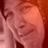

Predicted label: happy
True label: sad


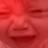

Predicted label: happy
True label: angry


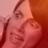

Predicted label: happy
True label: neutral


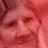

Predicted label: happy
True label: sad


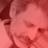

Predicted label: happy
True label: happy


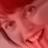

Predicted label: happy
True label: sad


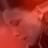

Predicted label: happy
True label: happy


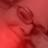

Predicted label: happy
True label: fear


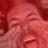

Predicted label: happy
True label: neutral


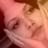

Predicted label: happy
True label: fear


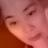

Predicted label: happy
True label: angry


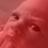

Predicted label: happy
True label: neutral


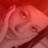

Predicted label: happy
True label: angry


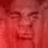

Predicted label: happy
True label: happy


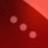

Predicted label: happy
True label: angry


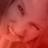

Predicted label: happy
True label: surprise


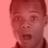

Predicted label: happy
True label: happy


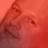

Predicted label: happy
True label: sad


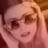

Predicted label: happy
True label: happy


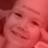

Predicted label: happy
True label: fear


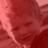

Predicted label: happy
True label: fear


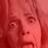

Predicted label: happy
True label: happy


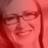

Predicted label: happy
True label: happy


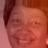

Predicted label: happy
True label: sad


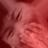

Predicted label: happy
True label: fear


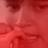

Predicted label: happy
True label: surprise


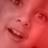

Predicted label: happy
True label: happy


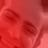

Predicted label: happy
True label: fear


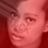

Predicted label: happy
True label: sad


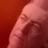

In [150]:

## 6. Loop over each image, predicted label and heatmap in order to display the images with the superimposed grad cam heatmap and the corresponding predicted label. Do they match the true label? What happens to the grad cam for wrong predictions? Are there any grad cams that seem surprising to you?

from pathlib import Path

for img, pred_label, true_label, heatmap in zip(imgs, pred_labels, labels, heatmaps):
  # We rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)

  # We use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # We create an image with RGB colorized heatmap
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.003 + img
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

  # Save the superimposed image
  save_path = "saved_img.jpg"
  superimposed_img.save(save_path)

  # Display Grad CAM
  pred_file_path = np.argmax(train_generator.labels == pred_label)
  pred_label_name = Path(train_generator.filepaths[pred_file_path]).parent.name

  true_file_path = np.argmax(train_generator.labels == tf.argmax(true_label))
  true_label_name = Path(train_generator.filepaths[true_file_path]).parent.name

  print("Predicted label:",pred_label_name)
  print("True label:", true_label_name)

  display(Image(save_path))